In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_supp_LP1 = "../svg/panel_supp_lp1.svg"
PANEL_supp_LP2 = "../svg/panel_supp_lp2.svg"
PANEL_supp_PY1 = "../svg/panel_supp_py1.svg"
PANEL_supp_PY2 = "../svg/panel_supp_py2.svg"

PANEL_supp_LP_EV1 = "../svg/panel_supp_lp_ev1.svg"
PANEL_supp_LP_EV2 = "../svg/panel_supp_lp_ev2.svg"
PANEL_supp_PY_EV1 = "../svg/panel_supp_py_ev1.svg"
PANEL_supp_PY_EV2 = "../svg/panel_supp_py_ev2.svg"

PANEL_supp_LP_syn1 = "../svg/panel_supp_lp_syn1.svg"
PANEL_supp_LP_syn2 = "../svg/panel_supp_lp_syn2.svg"
PANEL_supp_PY_syn1 = "../svg/panel_supp_py_syn1.svg"
PANEL_supp_PY_syn2 = "../svg/panel_supp_py_syn2.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

###  Fit regression net for total energy

In [7]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [14]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = "cpu"
    posterior._sample_with = "rejection"

In [15]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

# Energy per spike

In [16]:
num_test = 1000

In [17]:
theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [18]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["PY"].to_numpy()
all_energies_per_spike_ABPD_test = torch.as_tensor(
    all_energies_per_spike_ABPD[:num_test], dtype=torch.float32
).unsqueeze(1)
all_energies_per_spike_ABPD_train = torch.as_tensor(
    all_energies_per_spike_ABPD[num_test:], dtype=torch.float32
).unsqueeze(1)

In [19]:
torch.manual_seed(0)

sensitivity_e_per_spike = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_e_per_spike = sensitivity_e_per_spike.add_property(
    theta_train, all_energies_per_spike_ABPD_train, hidden_features=20, num_blocks=1
).train()
predictions = converged_nn_e_per_spike(theta_test).detach().numpy()
e_vals_e_per_spike, e_vecs_e_per_spike = sensitivity_e_per_spike.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

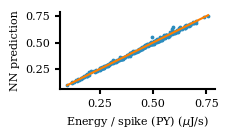

In [20]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()/1000
    unnorm_y = predictions[:300]/1000
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike (PY) ($\mu$J/s)")
    ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


Ratio of first to second eigenvalue:  tensor(32.2492)


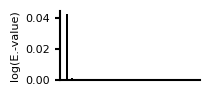

In [21]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_e_per_spike), dims=(0,)),
        figsize=(1.8, 0.9),
        ylabel="log(E.-value)",
        color="k",
        title=None,
        xlabel=False
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_supp_PY_EV1, facecolor="None", transparent=False)
    plt.show()

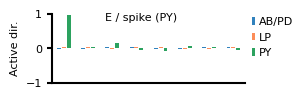

In [22]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        deepcopy(e_vecs_e_per_spike[:, -1].T),
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dir.",
        plot_labels=False,
        legend=True,
        title='E / spike (PY)',
        title_x_offset=-0.6,
        legend_y_offset=0.3,
    )
    plt.savefig(PANEL_supp_PY1, facecolor="None", transparent=True)
    plt.show()

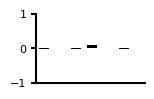

In [23]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_e_per_spike[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None, plot_labels=False
    )
    plt.savefig(PANEL_supp_PY_syn1, facecolor="None", transparent=False)
    plt.show()

## Number of spikes

In [24]:
numSpikesPerBurst = x["num_spikes"]["PY"].to_numpy() / x["num_bursts"]["PY"].to_numpy()
numSpikesPerBurst_test = torch.as_tensor(
    numSpikesPerBurst[:num_test], dtype=torch.float32
).unsqueeze(1)
numSpikesPerBurst_train = torch.as_tensor(
    numSpikesPerBurst[num_test:], dtype=torch.float32
).unsqueeze(1)

In [25]:
torch.manual_seed(0)

sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_num_spikes = sensitivity_num_spikes.add_property(
    theta_train,
    numSpikesPerBurst_train,
    hidden_features=20,
    num_blocks=1
).train(max_num_epochs=100)
e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
predictions = converged_nn_num_spikes(theta_test).detach().numpy()

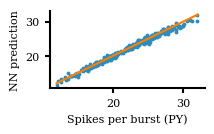

In [27]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = numSpikesPerBurst_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst (PY)")
    ax.set_ylabel("NN prediction")
#     plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(34.3654)


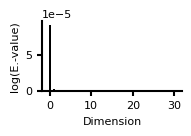

In [28]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_num_spikes), dims=(0,)),
        figsize=(1.8, 0.9),
        ylabel="log(E.-value)",
        color="k",
        title=None,
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
    )
    plt.savefig(PANEL_supp_PY_EV2, facecolor="None", transparent=False)
    plt.show()

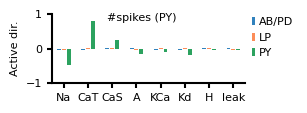

In [29]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs_num_spikes[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dir.",
        plot_labels=True,
        legend=True,
        legend_y_offset=0.3,
        title='#spikes (PY)',
        title_x_offset=-0.5,
    )
    plt.savefig(PANEL_supp_PY2, facecolor="None", transparent=True)
    plt.show()

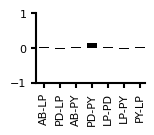

In [30]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_num_spikes[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None
    )
    plt.savefig(PANEL_supp_PY_syn2, facecolor="None", transparent=False)
    plt.show()

# Relationship between the two

In [31]:
projected_e_per_spike = sensitivity_e_per_spike.project(theta_train, num_dimensions=1)
projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

In [32]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
# ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 0)
# ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [33]:
cond1 = projected_e_per_spike > -1.5
cond2 = projected_e_per_spike < -0.3
cond3 = projected_num_spikes > -1.2
cond4 = projected_num_spikes < -0.1

In [34]:
full_cond = torch.logical_and(
    torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4
)

In [35]:
fulfiling_param_sets = theta_train[full_cond[:, 0]]
print(fulfiling_param_sets.shape)

torch.Size([50, 31])


In [36]:
parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = sensitivity_e_per_spike.project(parameter_set1, num_dimensions=1)
parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = sensitivity_e_per_spike.project(parameter_set2, num_dimensions=1)
parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3 = theta_train[full_cond[:, 0]][2].unsqueeze(0)
parameter_set3_dim1 = sensitivity_e_per_spike.project(parameter_set3, num_dimensions=1)
parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

In [37]:
energy_PM = x["energies"]["PY"].to_numpy()
energy_PM_train = energy_PM[num_test:]

In [38]:
v1 = e_vecs_num_spikes[:, -1]
v2 = e_vecs_e_per_spike[:, -1]
norm_v1 = torch.norm(v1)
dot_prod = torch.dot(v1, v2).item()
angle = math.acos(dot_prod)
print("angle in rad:", angle)
print("angle in deg:", angle / 2 / math.pi * 360)

angle_within_90deg = math.pi - angle
my_ticker = ticker.FixedFormatter([-2, 0, 2])

angle in rad: 1.944740016223899
angle in deg: 111.42539517983265


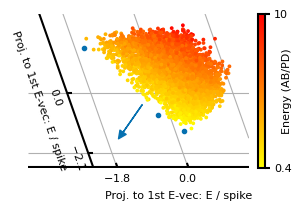

In [39]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.1, 2.0))
    viz.curvelinear_test1(
        fig,
        angle_within_90deg,
        projected_num_spikes,
        projected_e_per_spike,
        energy_PM_train,
        parameter_set1_dim1,
        parameter_set1_dim2,
        parameter_set2_dim1,
        parameter_set2_dim2,
        parameter_set3_dim1,
        parameter_set3_dim2,
    )
#     plt.savefig(PANEL_F1, facecolor="None", transparent=True)
    plt.show()

## Assemble figure

In [40]:
time_vec = np.arange(0, 11000, 0.025)

In [41]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [42]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "10.4cm",

    Panel(
          SVG(PANEL_supp_LP_EV1).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(2.0*factor_svg, 1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_LP1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(44.0*factor_svg, 1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_LP_syn1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(96.0*factor_svg, 0.3*factor_svg),

    Panel(
          SVG(PANEL_supp_LP_EV2).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -6*factor_svg, 3.5*factor_svg, **kwargs_text),
    ).move(6.0*factor_svg, 80+1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_LP2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(44.0*factor_svg, 83+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_LP_syn2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(96.0*factor_svg, 90+0.3*factor_svg),

    Panel(
          SVG(PANEL_supp_PY_EV1).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -3*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(3.0*factor_svg, 180+1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_PY1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(44.0*factor_svg, 173+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_PY_syn1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(96.0*factor_svg, 180+0.3*factor_svg),

   Panel(
          SVG(PANEL_supp_PY_EV2).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", -6*factor_svg, 4.5*factor_svg, **kwargs_text),
    ).move(6.0*factor_svg, 260+1.0*factor_svg),

    Panel(
          SVG(PANEL_supp_PY2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(44.0*factor_svg, 263+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_PY_syn2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(96.0*factor_svg, 270+0.3*factor_svg),


)

!mkdir -p fig
f.save("../fig/fig3_supp5.svg")
svg('../fig/fig3_supp5.svg')